## Anomalous Sensor Detection and Filtering Data to the IoT Gateway using LSTM's

Dataset: http://db.csail.mit.edu/labdata/labdata.html

The goal of this exercise is to detect anomalies and filter time-series data streams. By reducing the amount of data sent from the sensor to the gateway, we can increase data throughput and decrease network latency.
    
    - Can we infer data from sensors that are close to other sensors?

### Data Loading

In [1]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
with gzip.open('data.txt.gz', 'rb') as data_bytes:
    data = pd.read_csv(data_bytes, header=None, sep=' ', parse_dates=[[0, 1]])
data.columns = ['DATETIME','EPOCH','MOTE_ID','TEMPERATURE','HUMIDITY','LIGHT','VOLTAGE']
data.head()

,DATETIME,EPOCH,MOTE_ID,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE
0,2004-03-31 03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397
1,2004-02-28 00:59:16.027850,3,1.0,19.9884,37.09330,45.08,2.69964
2,2004-02-28 01:03:16.333930,11,1.0,19.3024,38.46290,45.08,2.68742
3,2004-02-28 01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742
4,2004-02-28 01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964


In [3]:
data.describe()

,EPOCH,MOTE_ID,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE
count,2.313682e+06,2.313156e+06,2.312781e+06,2.312780e+06,2.219804e+06,2.313156e+06
mean,3.303993e+04,2.854412e+01,3.920700e+01,3.390814e+01,4.072110e+02,2.492552e+00
std,1.836852e+04,5.062408e+01,3.741923e+01,1.732152e+01,5.394276e+02,1.795743e-01
min,0.000000e+00,1.000000e+00,-3.840000e+01,-8.983130e+03,0.000000e+00,9.100830e-03
25%,1.757200e+04,1.700000e+01,2.040980e+01,3.187760e+01,3.956000e+01,2.385220e+00
50%,3.332700e+04,2.900000e+01,2.243840e+01,3.928030e+01,1.582400e+02,2.527320e+00
75%,4.778900e+04,4.100000e+01,2.702480e+01,4.358550e+01,5.372800e+02,2.627960e+00
max,6.553500e+04,6.540700e+04,3.855680e+02,1.375120e+02,1.847360e+03,1.856000e+01


In [4]:
data.dtypes

DATETIME       datetime64[ns]
EPOCH                   int64
MOTE_ID               float64
TEMPERATURE           float64
HUMIDITY              float64
LIGHT                 float64
VOLTAGE               float64
dtype: object

Next, let's load proximity data for each of the sensors and plot their spatial locality.

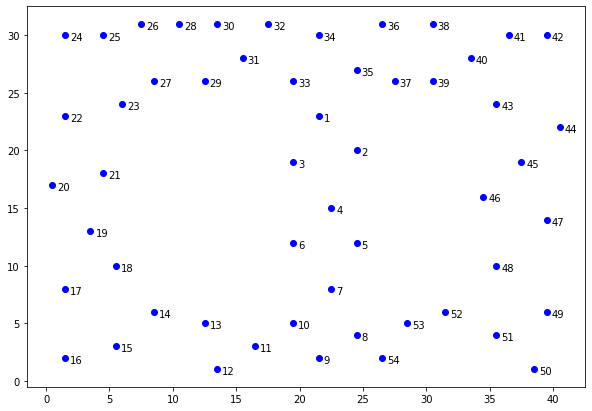

In [5]:
mote_loc_data = pd.read_csv('mote_loc.txt', header=None, sep=' ')
mote_loc_data.columns = ['MOTE_ID', 'X', 'Y']

plt.figure(figsize=(10,7))
plt.scatter(mote_loc_data.X, mote_loc_data.Y, c='blue')
mote_label = [i for i in range(1,len(mote_loc_data)+1)]
for label, x, y in zip(mote_label, mote_loc_data.X, mote_loc_data.Y):
    plt.annotate(
        label, xy=(x,y),
        xytext=(5, -5),
        textcoords='offset points'
    )

### TODO: Load probabilities file - will be used for determining if another nearby mote should be read. Once LSTM is this could be useful for biasing

### Data Cleanup

In [6]:
data.isna().sum()

DATETIME           0
EPOCH              0
MOTE_ID          526
TEMPERATURE      901
HUMIDITY         902
LIGHT          93878
VOLTAGE          526
dtype: int64

First, consider the MOTE_ID. If the mote_id is null, then clearly their is either a misreading or the dataset has errors. We can sefely drop these datapoints since they have no observation data, nor do they give information on what sensor is doing the reading. Likewise, we can eliminate all data from sensors labeled > 54, as there are only 54 sensors in our array.

In [7]:
data.dropna(subset=['MOTE_ID'], inplace=True)
data = data[data.MOTE_ID <= len(mote_loc_data)]

We can now make MOTE_ID an integer, leaving all other attributes. Also, note the missing VOLTAGE values corresponded to the missing MOTE_ID.

In [8]:
data.MOTE_ID = data.MOTE_ID.astype(int)

Second, consider the LIGHT, TEMPERATURE, and HUMIDITY columns.

Missing light values account for ~4% of the overall dataset, but we can fill those values with the mean of our light data and not expect much change in variance. However, we will fill these values based on average hourly values to further reduce variance.

In [9]:
missing_light = data[data.LIGHT.isna()].copy()
hourly_lux_averages = data.groupby(data.DATETIME.dt.hour).LIGHT.mean()
for hour in range(len(hourly_lux_averages)):
    missing_light.loc[missing_light.DATETIME.dt.hour == hour, 'LIGHT'] = hourly_lux_averages[hour]

We can then merge these values back into our original dataset.

In [10]:
data.update(missing_light)

Missing TEMPERATURE and HUMIDITY values account for even less, so by a similar reasoning, applying a mean seems reasonable.

In [11]:
missing_temp, missing_hum = data[data.TEMPERATURE.isna()].copy(), data[data.HUMIDITY.isna()].copy()
hourly_temp_averages, hourly_humidity_averages = data.groupby(data.DATETIME.dt.hour).TEMPERATURE.mean(), data.groupby(data.DATETIME.dt.hour).HUMIDITY.mean()
for hour in range(len(hourly_temp_averages)):
    missing_temp.loc[missing_temp.DATETIME.dt.hour == hour, 'TEMPERATURE'] = hourly_temp_averages[hour]
    missing_hum.loc[missing_hum.DATETIME.dt.hour == hour, 'HUMIDITY'] = hourly_humidity_averages[hour]
    
data.update(missing_hum)
data.update(missing_temp)
data.isna().sum()

DATETIME       0
EPOCH          0
MOTE_ID        0
TEMPERATURE    0
HUMIDITY       0
LIGHT          0
VOLTAGE        0
dtype: int64

Our data is now merged and we have a clean set to work with.

In [12]:
data.describe()

,EPOCH,MOTE_ID,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE
count,2.303290e+06,2.303290e+06,2.303290e+06,2.303290e+06,2.303290e+06,2.303290e+06
mean,3.295917e+04,2.837833e+01,3.928489e+01,3.388467e+01,4.056657e+02,2.490954e+00
std,1.833569e+04,1.487177e+01,3.747617e+01,1.734700e+01,5.352912e+02,1.781192e-01
min,0.000000e+00,1.000000e+00,-3.840000e+01,-8.983130e+03,0.000000e+00,9.100830e-03
25%,1.752200e+04,1.700000e+01,2.041960e+01,3.187760e+01,4.316980e+01,2.385220e+00
50%,3.317700e+04,2.900000e+01,2.244820e+01,3.928030e+01,1.582400e+02,2.527320e+00
75%,4.762575e+04,4.100000e+01,2.707380e+01,4.358550e+01,5.667200e+02,2.627960e+00
max,6.553500e+04,5.400000e+01,3.855680e+02,1.375120e+02,1.847360e+03,1.856000e+01


Here is a visualization on our observable variables.

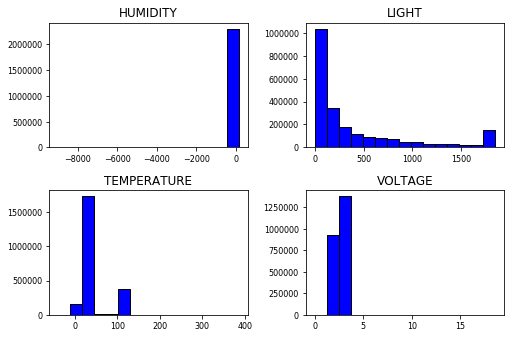

In [20]:
data[['TEMPERATURE', 'HUMIDITY', 'LIGHT', 'VOLTAGE']].hist(bins=15, color='blue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))  

Clearly there are still some outliers remaining, but we will leave them to the LSTM to discover if they are useful or not.